## Generate plots over subareas from Pandora H(x) IODA files
This notebook will generate horizontal scatter plot for Pandora stations over user-defined subareas.

In [1]:
import os
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
from functions import set_size, get_dates

### Setup the script running period, features of figure

In [2]:
# Setup the size of title and texts in the plot
tlsize = 12
txsize = 12
mpl.rc('axes', titlesize=tlsize, labelsize=txsize)
mpl.rc('xtick', labelsize=txsize)
mpl.rc('ytick', labelsize=txsize)
mpl.rc('legend', fontsize='small')

# Figure size control
axe_w = 4
axe_h = 4
plot_quality = 600
# Colorbar control
cb_ori = 'vertical'
cb_frac = 0.025
cb_pad = 0.04
cb_asp = 32
# Projection control
projection_like = 'wxaq'

# Define sub area [minlon, maxlon, minlat, maxlat]
sub_areas = {
    'Boston': [-72., -70., 42., 43.],
    'NewYork': [-75.6, -72.4, 39.8, 41.4],
    'Toronto': [-80., -78., 43., 44.],
}

srcpath = '/glade/work/swei/Git/JEDI-METplus'

plot_product = 'wrfchem_evaluate'
obs_name = 'pandora_no2_total-wxaq'

# Variable name in IODA files
plot_var = 'nitrogendioxideTotal'
# units_str = 'mol m$^{-2}$'
units_str = '10$^{15}$ molec cm$^{-2}$'

# Level control
vmin = 0
vmax = 10.

# Period control: vrfy_fhr defines which f{vrfy_fhr} folder to be searched and plotted.
vrfy_fhr = 19
sdate = 2024082419
edate = 2024082419
hint = 24
dates = get_dates(sdate, edate, hint)

### Setup default variable name, units, paths, and Cartopy projection

In [3]:
varstr_dict = {
    'nitrogendioxideTotal': 'Total NO$_{2}$',
}
varstr = varstr_dict[plot_var]
units_factors_dict = {
    'mol m$^{-2}$': 1.,
    '10$^{15}$ molec cm$^{-2}$': 6.022e4,
}

# Setup the path for H(x) IODA files
hofx_path = os.path.join(srcpath, 'output', plot_product, 'hofx',
                         'f%.2i' % (vrfy_fhr), obs_name)

# Setup the path to save plots
plts_path = os.path.join(srcpath, 'output', plot_product, 'plots', '2dmap', obs_name)

if not os.path.exists(hofx_path):
    raise Exception(f'HofX folder: {hofx_path} is not available')

if not os.path.exists(plts_path):
    os.makedirs(plts_path)

# Setup projection
if projection_like == 'wxaq':
    proj = ccrs.LambertConformal(central_longitude=-97.0,
                                 central_latitude=39.0,
                                 standard_parallels=[30., 60.])
if projection_like == 'glb':
    proj = ccrs.PlateCarree()

### Loop over different cycles to plot subarea figures

Processing: hofx.pandora_no2_total-wxaq.2024082419.nc4
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/2dmap/pandora_no2_total-wxaq/Boston.ObsValue.nitrogendioxideTotal.f19.2024082419.png
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/2dmap/pandora_no2_total-wxaq/NewYork.ObsValue.nitrogendioxideTotal.f19.2024082419.png
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/2dmap/pandora_no2_total-wxaq/Toronto.ObsValue.nitrogendioxideTotal.f19.2024082419.png
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/2dmap/pandora_no2_total-wxaq/Boston.hofx.nitrogendioxideTotal.f19.2024082419.png
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/2dmap/pandora_no2_total-wxaq/NewYork.hofx.nitrogendioxideTotal.f19.2024082419.png
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/2dmap/pandora_no2_total-wxaq/Toronto.hofx.nitrogendioxideTotal.f19.2024082419.png
Process Finished


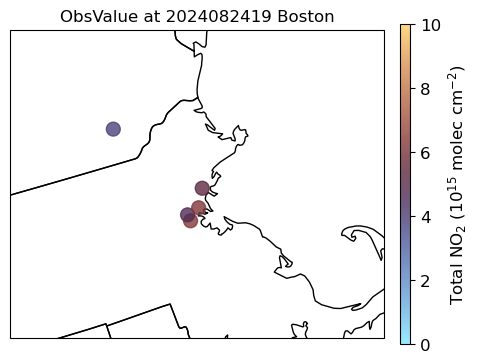

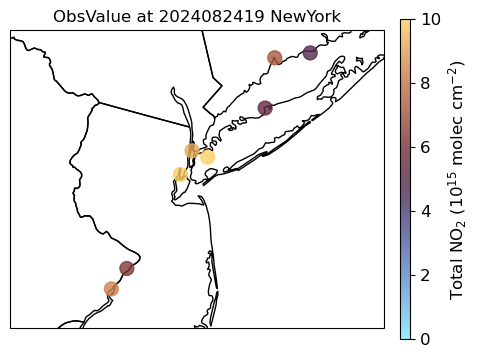

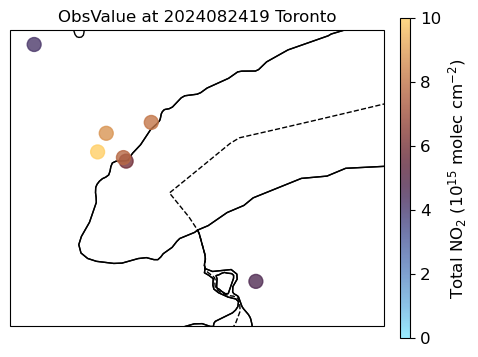

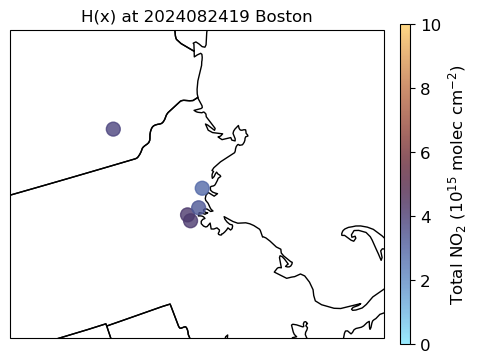

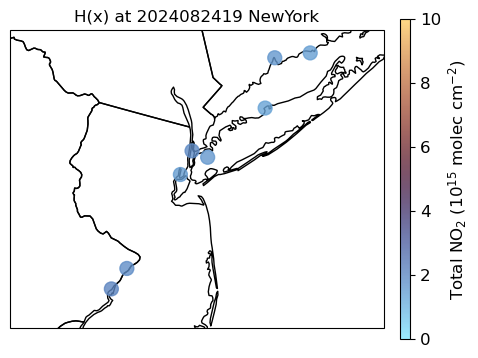

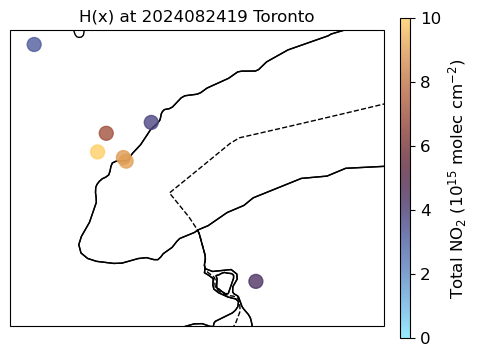

In [4]:
for cdate in dates:
    plot_date = cdate.strftime('%Y%m%d%H')
    hofx_file = f'hofx.{obs_name}.{plot_date}.nc4'
    print(f'Processing: {hofx_file}')
    in_hofx = os.path.join(hofx_path, hofx_file)
    if not os.path.exists(in_hofx):
        print(f'WARNING: Skip {plot_date}, {hofx_file} is not available')
        continue

    raw_ds = xr.open_dataset(in_hofx)
    meta_ds = xr.open_dataset(in_hofx, group='MetaData')
    lons = meta_ds.longitude
    lats = meta_ds.latitude

    obsval_ds = xr.open_dataset(in_hofx, group='ObsValue')
    hofx_ds = xr.open_dataset(in_hofx, group='hofx')
    preqc_ds = xr.open_dataset(in_hofx, group='PreQC')

    varname = plot_var
    df = meta_ds.to_dataframe()
    df['ObsValue'] = obsval_ds[varname].values * units_factors_dict[units_str]
    df['hofx'] = hofx_ds[varname].values * units_factors_dict[units_str]
    df['preqc'] = preqc_ds[varname].values
    pltdf = df.groupby(['latitude', 'longitude'])[['ObsValue', 'hofx']].mean().reset_index()

    for plot_type in ['ObsValue', 'H(x)']:
        if plot_type == 'ObsValue':
            pltcolumn = 'ObsValue'
        if plot_type == 'H(x)':
            pltcolumn = 'hofx'

        for sub_area_name in sub_areas.keys():
            minlon, maxlon, minlat, maxlat = sub_areas[sub_area_name]

            fig = plt.figure()
            ax = plt.subplot(projection=proj)
            set_size(axe_w, axe_h, t=0.96, l=0.14, b=0.1, r=0.86)
            ax.set_extent((minlon, maxlon, minlat, maxlat), crs=ccrs.PlateCarree())
            gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
            gl.xlines = False
            gl.ylines = False
            sc = ax.scatter(pltdf['longitude'], pltdf['latitude'], c=pltdf[pltcolumn], s=100,
                            vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),
                            cmap='managua_r', alpha=0.8, zorder=5)

            ax.add_feature(cft.BORDERS.with_scale('10m'), linestyle='--')
            if projection_like == 'glb':
                ax.coastlines(resolution='110m')
            if projection_like == 'wxaq':
                ax.add_feature(cft.STATES.with_scale('10m'))
                ax.add_feature(cft.LAKES.with_scale('10m'), facecolor='None',
                               edgecolor='k')

            title_str = f'{plot_type} at {plot_date} {sub_area_name}'
            cb_str = f'{varstr} ({units_str})'
            ax.set_title(title_str)
            cb = plt.colorbar(sc, orientation=cb_ori, fraction=cb_frac, pad=cb_pad, aspect=cb_asp, label=cb_str)
            cb.set_label(cb_str, fontsize=txsize)

            # If use 'mol m$^{-2}$' as units, uncomment the line below for colorbar in scientific notation.
            # cb.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
            
            plotname = f'{sub_area_name}.{pltcolumn}.{varname}.f{vrfy_fhr}.{plot_date}.png'
            outname = os.path.join(plts_path, plotname)
            print(outname)
            fig.savefig(outname, dpi=plot_quality)
            
print('Process Finished')